In [422]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
%matplotlib inline
import librosa
from librosa import display
import torch.nn as nn
import scipy.io.wavfile as wav
from numpy import inf
import pylab

In [3]:
def countParams(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
countParams(UNet(1,1))

NameError: name 'UNet' is not defined

In [ ]:
def train_net(net,
              device,
              epochs=5,
              batch_size=1,
              lr=0.001,
              val_percent=0.1,
              save_cp=True,
              img_scale=0.5):

    dataset = BasicDataset(dir_img, dir_mask, img_scale)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train, val = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

    writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
    global_step = 0

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {lr}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_cp}
        Device:          {device.type}
        Images scaling:  {img_scale}
    ''')

    optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)
    if net.n_classes > 1:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                imgs = batch['image']
                true_masks = batch['mask']
                assert imgs.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if net.n_classes == 1 else torch.long
                true_masks = true_masks.to(device=device, dtype=mask_type)

                masks_pred = net(imgs)
                loss = criterion(masks_pred, true_masks)
                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()

                pbar.update(imgs.shape[0])
                global_step += 1
                if global_step % (n_train // (10 * batch_size)) == 0:
                    for tag, value in net.named_parameters():
                        tag = tag.replace('.', '/')
                        writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                        writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                    val_score = eval_net(net, val_loader, device)
                    scheduler.step(val_score)
                    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], global_step)

                    if net.n_classes > 1:
                        logging.info('Validation cross entropy: {}'.format(val_score))
                        writer.add_scalar('Loss/test', val_score, global_step)
                    else:
                        logging.info('Validation Dice Coeff: {}'.format(val_score))
                        writer.add_scalar('Dice/test', val_score, global_step)

                    writer.add_images('images', imgs, global_step)
                    if net.n_classes == 1:
                        writer.add_images('masks/true', true_masks, global_step)
                        writer.add_images('masks/pred', torch.sigmoid(masks_pred) > 0.5, global_step)

        if save_cp:
            try:
                os.mkdir(dir_checkpoint)
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(net.state_dict(),
                       dir_checkpoint + f'CP_epoch{epoch + 1}.pth')
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()

In [ ]:
for epoch in range(epochs):
    net.train()
    epochLoss=0
    with tqdm(total=nTrain, desc=f"Epoch {epoch+1}/{epochs}", unit='spec') as pbar:
        for batch in trainLoader:
            noisySpecs=batch['revd']
            cleanSpecs=batch['clean']
            
            predSpecs=net(noisySpecs)
            loss=criterion(predSpecs, cleanSpecs)
            epochLoss+=loss.item()
            writer.add_scaler('Train loss': loss.item(), global_step)
            pbar.set_postfix(**{'loss (batch)':loss.item()})
            
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(net.parameters(), 0.1)
            optimizer.step()
            pbar.update(specs.shape[0])
            globalStep+=1
            
            
            
            

### Convert to Spectrogram and back

In [353]:
import torch
import torchaudio
import requests
import scipy
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as signal
from matplotlib import pyplot as plt
orgfilename="/Users/zombie/Downloads/CNN-for-single-channel-speech-enhancement-master/audiosample/test1_inf.wav"
noisyfilename="/Users/zombie/Downloads/CNN-for-single-channel-speech-enhancement-master/audiosample/test1_org.wav"
f="/Users/zombie/Downloads/LJSpeech-1.1/wavs/LJ001-0048.wav"
j="/Users/zombie/Downloads/LJSpeech-1.1/reverbedWavs/LJ001-0048.wav"

In [356]:
_, d=scipy.io.wavfile.read(f)

/Users/zombie/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


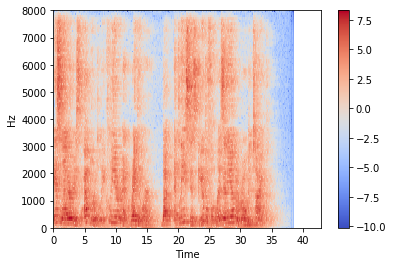

In [302]:
librosa.display.specshow(np.log(np.abs(Zxx)), sr=16000, x_axis="time", y_axis="hz")
plt.colorbar()

/Users/zombie/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


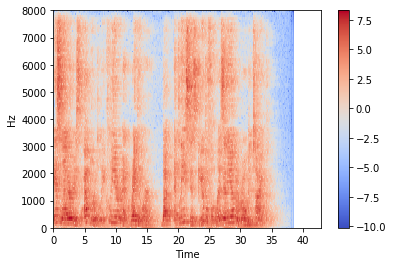

In [310]:
librosa.display.specshow(np.log(np.abs(Zxx)), sr=16000, x_axis="time", y_axis="hz")
plt.colorbar()

/Users/zombie/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


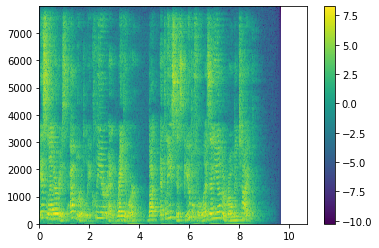

In [366]:
sample_rate, samples = wav.read(j)
f, t, Zxx = signal.stft(samples, fs=16000, nperseg=511, noverlap=385, padded=False)
plt.pcolormesh(t, f, np.log(np.abs(Zxx)))
plt.colorbar()
plt.savefig('temp.png')

In [331]:
librosa.load(j)

(array([ 3.0517578e-05,  4.8828125e-04, -9.1552734e-05, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32), 22050)

array([ 1, 16, -3, ...,  0,  0,  0], dtype=int16)

In [21]:
file, sr=librosa.load(f, sr=16000)
rev, _=librosa.load(j, sr=16000)

In [246]:
audio, sr = librosa.load(f)
D = np.abs(librosa.stft(audio))**2
audio= librosa.feature.melspectrogram(y=audio, sr=sr, S=D)

In [463]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [470]:
pylab.figure(figsize=(5,5))
pylab.axis('off') 
pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
librosa.display.specshow(librosa.power_to_db(np.abs(temp)**2),y_axis='hz', x_axis='time')
pylab.savefig('temp.jpg', bbox_inches=None, pad_inches=0)
pylab.close()

In [1]:
from PIL import Image
temp=Image.open('temp.jpg')

In [4]:
import numpy as np

In [5]:
np.array(temp)

array([[[ 60,  77, 193],
        [ 58,  75, 191],
        [ 65,  82, 198],
        ...,
        [254, 181, 148],
        [245, 176, 147],
        [245, 175, 149]],

       [[ 60,  77, 193],
        [ 59,  76, 192],
        [ 66,  83, 199],
        ...,
        [254, 179, 147],
        [244, 175, 146],
        [245, 175, 149]],

       [[ 59,  76, 192],
        [ 58,  75, 191],
        [ 66,  83, 199],
        ...,
        [253, 178, 146],
        [245, 176, 147],
        [245, 175, 149]],

       ...,

       [[190, 214, 242],
        [189, 213, 251],
        [174, 197, 251],
        ...,
        [219, 114,  92],
        [215,  85,  71],
        [220,  84,  72]],

       [[190, 214, 242],
        [189, 213, 251],
        [173, 196, 250],
        ...,
        [218, 116,  93],
        [213,  86,  71],
        [220,  84,  72]],

       [[189, 213, 241],
        [188, 212, 250],
        [173, 196, 250],
        ...,
        [216, 116,  93],
        [213,  86,  71],
        [221,  85,  73]]